# Assessment template for data p01

will be using the Constraint satisfaction problem algo (CSP)

In [14]:
# Install contraint lybrary
%pip install python-constraint

import time

from constraint import Problem
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# If using Colab to upload files, if locally wont work

from google.colab import files
# Expected name for this example `p01_dataset_8.txt`

uploaded = files.upload()

for fn in uploaded.keys():
	print('User uploaded file "{name}" with length {length} bytes'.format(
			name=fn, length=len(uploaded[fn])))



Define the file to use as dataSet

In [16]:
# Expected name for this example `p01_dataset_8`
file_path = input("Enter the path path") or "p01_dataset_8.txt";
# file_path = "p01_dataset_8.txt"


### Data structures definition for parsed data

In [17]:
class GeneralInformation:
    def __init__(
        self,
        projects,
        jobs,
        horizon,
        renewable_resources,
        nonrenewable_resources,
        doubly_constrained_resources,
    ):
        self.projects = projects
        self.jobs = jobs
        self.horizon = horizon
        self.resources = {
            "renewable": renewable_resources,
            "nonrenewable": nonrenewable_resources,
            "doubly_constrained": doubly_constrained_resources,
        }

    def __str__(self):
        return "\n".join(
            [
                f"Projects: {self.projects}",
                f"Jobs: {self.jobs}",
                f"Horizon: {self.horizon}",
                f"Resources: {self.resources}",
            ]
        )


class ProjectSummary:
    def __init__(
        self, project_number, jobs, release_date, due_date, tardiness_cost, mpm_time
    ):
        self.project_number = project_number
        self.jobs = jobs
        self.release_date = release_date
        self.due_date = due_date
        self.tardiness_cost = tardiness_cost
        self.mpm_time = mpm_time

    def __str__(self):
        return "\n".join(
            [
                f"  - Project Number: {self.project_number}",
                f"\tJobs: {self.jobs}",
                f"\tRelease Date: {self.release_date}",
                f"\tDue Date: {self.due_date}",
                f"\tTardiness Cost: {self.tardiness_cost}",
                f"\tMPM Time: {self.mpm_time}",
            ]
        )


class Job:
    def __init__(self, job_number, successors):
        self.job_number = job_number
        self.successors = successors

    def get_successors_count(self):
        return len(self.successors)

    def __str__(self):
        return "\n".join(
            [
                f"  - Job Number: {self.job_number}",
                f"\tSuccessors Count: {self.get_successors_count()}",
                f"\tSuccessors: {', '.join(map(str, self.successors)) if self.successors else 'None'}",
            ]
        )


class DurationResource:
    def __init__(self, job_number, mode, duration, resources):
        self.job_number = job_number
        self.mode = mode
        self.duration = duration
        self.resources = resources

    def __str__(self):
        return "\n".join(
            [
                f"  - Job Number: {self.job_number}",
                f"\tMode: {self.mode}",
                f"\tDuration: {self.duration} days",
                f"\tResources: {', '.join([f'{key}: {value}' for key, value in self.resources.items()]) if self.resources else 'None'}",
            ]
        )


class ResourceAvailability:
    def __init__(self, resource_name, quantity):
        self.resource_name = resource_name
        self.quantity = quantity

    def __str__(self):
        return f"  - Resource: {self.resource_name}\n\tQuantity: {self.quantity}"


In [18]:
# Definition for data loaded
class ProjectData:
    def __init__(self):
        self.general_info = None
        self.projects_summary = []
        self.precedence_relations = []
        self.durations_resources = []
        self.resource_availability = {}

    def __str__(self):
        result = []

        # General Info
        result.append("General Information:")
        if self.general_info:
            result.append(str(self.general_info))
        else:
            result.append("  None")

        # Projects Summary
        result.append("\nProjects Summary:")
        if self.projects_summary:
            for summary in self.projects_summary:
                result.append(str(summary))
        else:
            result.append("  None")

        # Precedence Relations
        result.append("\nPrecedence Relations:")
        if self.precedence_relations:
            for relation in self.precedence_relations:
                result.append(str(relation))
        else:
            result.append("  None")

        # Durations and Resources
        result.append("\nDurations and Resources:")
        if self.durations_resources:
            for resource in self.durations_resources:
                result.append(str(resource))
        else:
            result.append("  None")

        # Resource Availability
        result.append("\nResource Availability:")
        if self.resource_availability:
            for name, resource in self.resource_availability.items():
                result.append(str(resource))
        else:
            result.append("  None")

        return "\n".join(result)


## Data parsing function

In [19]:
def parse_data(file) -> ProjectData:
    data = ProjectData()
    # Track the file section
    section = None

    for line in file:
        line = line.strip()

        # Skip ornament and invalid
        if line.startswith("**") or not line:
            continue

        if line.startswith("#"):
            # Match the file section
            match line:
                case "#General Information":
                    section = "general_info"
                    continue
                case "#Projects summary":
                    section = "projects_summary"
                    continue
                case "#Precedence relations":
                    section = "precedence_relations"
                    continue
                case "#Duration and resources":
                    section = "durations_resources"
                    continue
                case "#Resource availability":
                    section = "resource_availability"
                    continue

        match section:
            case "general_info":
                if "projects" in line:
                    data.general_info = GeneralInformation(
                        int(line.split(":")[1].strip()),
                        jobs=0,
                        horizon=0,
                        renewable_resources=0,
                        nonrenewable_resources=0,
                        doubly_constrained_resources=0,
                    )
                elif "jobs" in line:
                    data.general_info.jobs = int(line.split(":")[1].strip())
                elif "horizon" in line:
                    data.general_info.horizon = int(line.split(":")[1].strip())
                elif line.startswith("- renewable"):
                    data.general_info.resources["renewable"] = int(
                        line.split(":")[1].split()[0].strip()
                    )
                elif line.startswith("- nonrenewable"):
                    data.general_info.resources["nonrenewable"] = int(
                        line.split(":")[1].split()[0].strip()
                    )
                elif line.startswith("- doubly constrained"):
                    data.general_info.resources["doubly_constrained"] = int(
                        line.split(":")[1].split()[0].strip()
                    )

            case "projects_summary":
                # Skip header line
                if line.startswith("pronr."):
                    continue

                splits = line.split()
                if splits:
                    data.projects_summary.append(
                        ProjectSummary(
                            project_number=int(splits[0]),
                            jobs=int(splits[1]),
                            release_date=int(splits[2]),
                            due_date=int(splits[3]),
                            tardiness_cost=int(splits[4]),
                            mpm_time=int(splits[5]),
                        )
                    )

            case "precedence_relations":
                # Skip header line
                if line.startswith("#jobnr."):
                    continue

                splits = line.split()
                if splits:
                    data.precedence_relations.append(
                        Job(
                            job_number=int(splits[0]),
                            successors=list(map(int, splits[3:])),
                        )
                    )

            case "durations_resources":
                # Skip header line
                if line.startswith("#jobnr."):
                    continue

                splits = line.split()
                if splits:
                    resourcesData = {}
                    for i in range(len(splits) - 3):
                        resourcesData[f"R{i+1}"] = int(splits[i + 3])

                    data.durations_resources.append(
                        DurationResource(
                            job_number=int(splits[0]),
                            mode=int(splits[1]),
                            duration=int(splits[2]),
                            resources=resourcesData,
                        )
                    )

            case "resource_availability":
                # Skip header line
                if line.startswith("#resource"):
                    continue

                splits = line.split()
                if splits:
                    name = splits[0]

                    data.resource_availability[name] = ResourceAvailability(
                        resource_name=name, quantity=int(splits[1])
                    )

    return data


# Defining the solver

### Problem BreakDown

- Variables: Each job can be seen as a variable. The value of this variable will be the start time of that job.
- Domains: The domain for each job variable will be the possible start times, considering the project’s time horizon.
- Constraints:
	- Precedence Constraints: A job cannot start before its predecessors are finished (if job A precedes job B, then job A’s end time must be before job B starts).
	- Resource Constraints: The number of resources (e.g., designers, programmers) is limited. So, at any given time, the total resources used by all jobs must not exceed the available resources.
	- Duration Constraints: Each job has a specific duration, so its end time is determined by its start time and duration.

In [20]:
# Precedence constrain function, a new job should only start if the precedents ended
def sucessor_constraint(start_job, start_successor, duration):
    return start_job + duration <= start_successor

In [21]:
# Resource constrain function, a new job should only start if the is resources available
def resource_constraint(*start_times, time_slots, project_data: ProjectData):
    usage_R1 = [0] * len(time_slots)
    usage_R2 = [0] * len(time_slots)

    # Update resources only for active times
    for job_index, start_time in enumerate(start_times):
        job_data = project_data.durations_resources[job_index]
        end_time = start_time + job_data.duration

        # Mark the resources used in the relevant time slots
        for t in range(start_time, end_time):
            if t >= len(time_slots):
                break  # Stay within time slots
            
            usage_R1[t] += job_data.resources["R1"]
            usage_R2[t] += job_data.resources["R2"]

    # Check if resources exceed availability
    for t in range(len(time_slots)):
        if (
            usage_R1[t] > project_data.resource_availability["R1"].quantity
            or usage_R2[t] > project_data.resource_availability["R2"].quantity
        ):
            return False  # Constraint violated

    return True

In [22]:
def define_problem(data: ProjectData):
    domain = range(data.general_info.horizon + 1)
    start_times = [f"job_{job.job_number}" for job in data.precedence_relations];

    problem = Problem()

    # Define variables for each job, and the domain are the available time on the horizon (20 days)
    for job in data.precedence_relations:
        number = job.job_number
        var_name = f"job_{number}"

        problem.addVariable(var_name, domain)

        for successor in job.successors:
            duration = data.durations_resources[job.job_number - 1].duration

            problem.addConstraint(
                lambda start_j, start_s, duration=duration: sucessor_constraint(
                    start_j, start_s, duration
                ),
                (f"job_{job.job_number}", f"job_{successor}"),
            )

    problem.addConstraint(
        lambda *start_times: resource_constraint(
            *start_times, time_slots=domain, project_data=data
        ),
        start_times,
    )

    return problem


Processing the results to remove the unnecessary offsets

In [23]:
def process_solution(solution, pData: ProjectData):
	has_preced = set() 

	for job in pData.precedence_relations:
		for pId in job.successors:
			has_preced.add(f"job_{pId}")

	min_offset = min(solution[key] for key in solution if key not in has_preced)

	for key in solution:
		solution[key] -= min_offset
	
	return solution;

## Draw

In [24]:
# Data: start days and durations
# Prepare data for the Gantt chart
def draw_solution(solution, pData: ProjectData):
    job_names = list(solution.keys())
    start_day = list(solution.values())

    duration = [pData.durations_resources[int(job.split('_')[1]) - 1].duration for job in job_names]

    # Plot the Gantt chart
    fig, ax = plt.subplots(figsize=(10, 6))

    # Horizontal bars
    ax.barh(job_names, duration, left=start_day, color='skyblue', edgecolor='black')

    # Add labels and grid
    ax.set_xlabel('Days')
    ax.set_ylabel('Jobs')
    ax.set_title(f'Job Schedule ({file_path})')
    ax.grid(True, axis='x', linestyle='--', alpha=0.6)

    # Annotate each job bar with its duration
    for i, job in enumerate(job_names):
        ax.text(start_day[i] + duration[i] / 2, i, f'{duration[i]} days', ha='center', va='center', color='black')

    plt.tight_layout()
    plt.show()

In [30]:
def plot_resource_usage(solution, project_data):
    horizon = max(value for  value in solution.values()) + 1
    resource_usage_R1 = [0] * horizon
    resource_usage_R2 = [0] * horizon

    # Compute resource usage
    for job_index, start_time in solution.items():
        job_number = int(job_index.split('_')[1]) - 1
        job_data = project_data.durations_resources[job_number]
        end_time = start_time + job_data.duration

        # Update resource usage for the duration of the job
        for t in range(start_time, end_time):
            if t < horizon:  # Stay within the horizon
                resource_usage_R1[t] += job_data.resources["R1"]
                resource_usage_R2[t] += job_data.resources["R2"]

    # Plot the resource usage
    time_slots = range(horizon)
    plt.figure(figsize=(10, 6))

    plt.plot(time_slots, resource_usage_R1, label="Resource R1", color="blue", marker="o")
    plt.plot(time_slots, resource_usage_R2, label="Resource R2", color="green", marker="o")

    # Plot resource availability as a horizontal line
    plt.axhline(
        y=project_data.resource_availability["R1"].quantity,
        color="blue",
        linestyle="--",
        label="R1 Availability"
    )
    plt.axhline(
        y=project_data.resource_availability["R2"].quantity,
        color="green",
        linestyle="--",
        label="R2 Availability"
    )

    # Add labels, legend, and title
    plt.xlabel("Time (Days)")
    plt.ylabel("Resource Usage")
    plt.title(f"Resource Occupation Over Time ({file_path})")
    plt.legend()
    plt.grid()

    plt.xticks(range(horizon))  

    # Show the plot
    plt.show()

 Output - {'job_1': 14, 'job_2': 16, 'job_4': 20, 'job_3': 16, 'job_5': 10, 'job_6': 12, 'job_8': 19, 'job_7': 12}
 Processed Output - {'job_1': 4, 'job_2': 6, 'job_4': 10, 'job_3': 6, 'job_5': 0, 'job_6': 2, 'job_8': 9, 'job_7': 2}


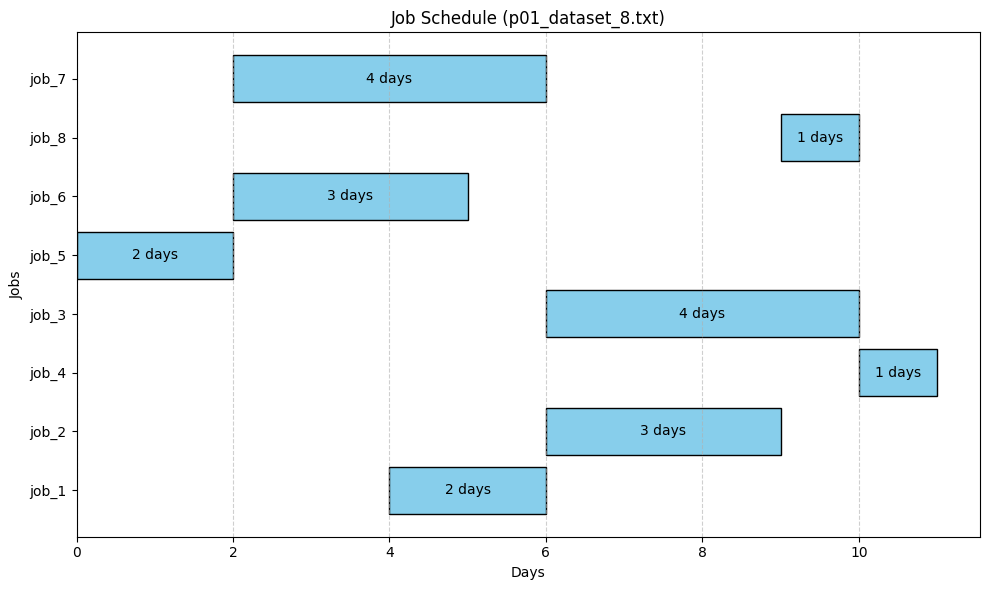

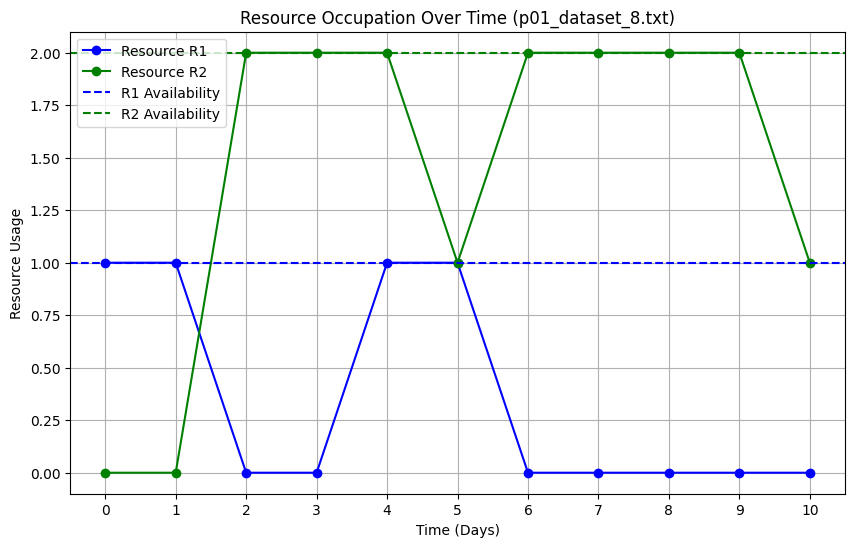

Execution time: 0.2788 seconds


In [31]:
start_time = time.time()

with open(file_path, "r") as file:
		proj_data = parse_data(file)


		problem = define_problem(proj_data)
		solution = problem.getSolution()

		if solution:
			print(f" Output - {solution}")

			processed_solution = process_solution(solution, proj_data)
			print(f" Processed Output - {solution}")

			draw_solution(solution, proj_data)
			plot_resource_usage(solution, proj_data)

end_time = time.time()
print(f"Execution time: {(end_time - start_time):.4f} seconds")
